In [2]:
import tensorflow as tf
import collections
import tensorflow_federated as tff

import numpy as np

In [3]:
import tensorflow.keras.backend as K
import gc

K.clear_session()  # Clear TF session to free GPU memory
gc.collect()

4

In [4]:
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.14.1


2026-02-16 11:16:49.744236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-16 11:16:50.239970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-16 11:16:50.243198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
)

kidney_dataset = datagen.flow_from_directory(
    '/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer',
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    batch_size=32,
)

Found 3498 images belonging to 2 classes.


Batch shape: (32, 224, 224, 3)
Single image shape: (224, 224, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Label [1. 0.]


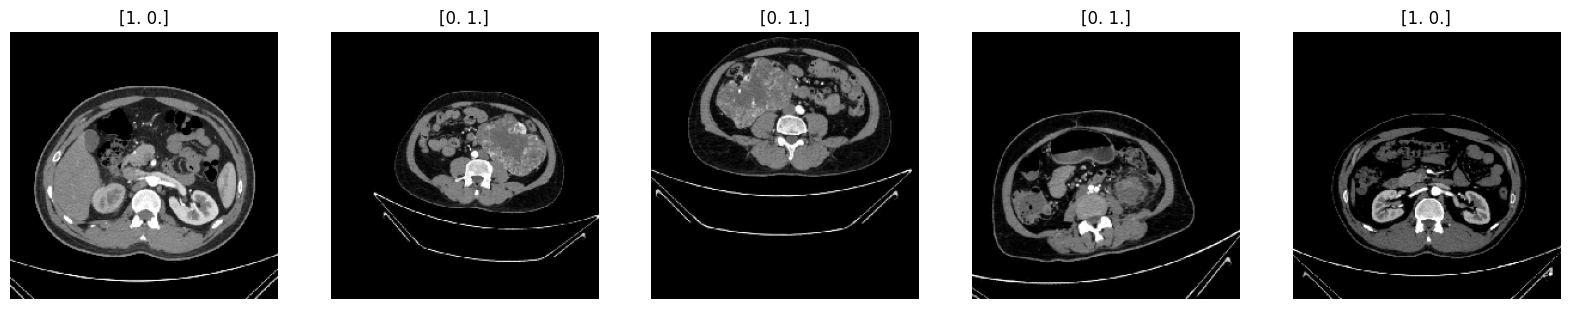

In [6]:
import matplotlib.pyplot as plt
images, labels = next(kidney_dataset)
for i in range(1):
    print("Batch shape:", images.shape)
    print("Single image shape:", images[0].shape)
    print("Min pixel value:", images.min())
    print("Max pixel value:", images.max())
    print("Label", labels[0])

fig, ax = plt.subplots(1, 5, figsize=(20,5))
for i in range(5):
    ax[i].imshow(images[i])
    ax[i].set_title(labels[i])
    ax[i].axis('off')

plt.show()


In [7]:
type(kidney_dataset)

keras.src.preprocessing.image.DirectoryIterator

In [8]:
import os

data_dir = '/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer'
class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
class_labels = {name: idx for idx, name in enumerate(class_names)}

print(class_labels)

image_paths = []
labels = []
for class_name in class_names:
    path1 = os.path.join(data_dir, class_name)
    print(path1)
    paths = os.listdir(path1)
    for path in paths:
        image_paths.append(os.path.join(path1, path))
        labels.append(class_labels[class_name])

print(image_paths[1])

{'kidney_normal': 0, 'kidney_tumor': 1}
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_normal
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_tumor
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_normal/kidney_normal_0403.jpg


In [9]:
NUM_MALICIOUS = 3
FLIP_PROB = 0.4

In [10]:
import os
import random

class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
class_labels = {name: idx for idx, name in enumerate(class_names)}

fake_clients = []

def load_image(path, img_size=(224, 224)):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img

def create_client_dataset(image_paths, label, img_size=(224, 224), flip=False, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42):
    images = []
    labels = []
    target_size=(64, 64)
    for i, path in enumerate(image_paths):
        img = load_image(path, img_size)
        img = tf.image.resize(img, target_size)
        images.append(img)
        labels.append(label[i])

    labels = np.array(labels, dtype=np.int32)
    if flip:
        rng = np.random.RandomState(seed)
        num_classes = len(np.unique(labels))
        n = len(labels)

        # randomly choose which samples to flip
        mask = rng.rand(n) < float(flip_prob)

        if mask.sum() > 0:
            rand_targets = rng.randint(0, num_classes, size=n)
            # ensure flipped label != original label
            rand_targets[rand_targets == labels] = (rand_targets[rand_targets == labels] + 1) % num_classes
            labels[mask] = rand_targets[mask]

    print(f"{len(images)}  {len(labels)}   malicious_client={flip}")
    ds = tf.data.Dataset.from_tensor_slices((images, labels.tolist()))
    ds = ds.shuffle(buffer_size=len(images)).batch(8)
    return ds


def prepare_client_dataset(data_dir, num_client, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42):
    image_paths = []
    labels = []

    class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
    class_labels = {name: idx for idx, name in enumerate(class_names)}
    print(class_labels)

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        paths = os.listdir(class_path)
        for path in paths:
            image_paths.append(os.path.join(class_path, path))
            labels.append(class_labels[class_name])

    #image_paths = image_paths[:4000]
    combined = list(zip(image_paths, labels))
    rng = random.Random(seed)
    rng.shuffle(combined)

    combined = combined[:4000]
    image_paths, labels = zip(*combined)

    malicious_clients = []

    all_client_ids = [f"client_{i}" for i in range(num_client)]
    if num_malicious > 0:
        num_malicious = min(num_malicious, num_client)
        malicious_clients = rng.sample(all_client_ids, k=num_malicious)
    print("Malicious clients selected:", malicious_clients)

    clients_datasets = {}
    total_images = len(image_paths)
    for i in range(num_client):
        client_id = "client_{}".format(i)
        start = i * total_images // num_client
        end = ((i + 1) * total_images) // num_client
        print(client_id, start, end)
        do_flip = client_id in malicious_clients
        clients_datasets[client_id] = create_client_dataset(image_paths[start:end], labels[start:end], flip=do_flip, img_size=(224, 224), num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42)

    return clients_datasets, malicious_clients


client_datasets, fake_clients = prepare_client_dataset(data_dir=data_dir, num_client=10, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42)

{'kidney_normal': 0, 'kidney_tumor': 1}
Malicious clients selected: ['client_7', 'client_5', 'client_1']
client_0 0 349


2026-02-16 11:16:51.170400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-16 11:16:51.173312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-16 11:16:51.175428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

349  349   malicious_client=False
client_1 349 699
350  350   malicious_client=True
client_2 699 1049
350  350   malicious_client=False
client_3 1049 1399
350  350   malicious_client=False
client_4 1399 1749
350  350   malicious_client=False
client_5 1749 2098
349  349   malicious_client=True
client_6 2098 2448
350  350   malicious_client=False
client_7 2448 2798
350  350   malicious_client=True
client_8 2798 3148
350  350   malicious_client=False
client_9 3148 3498
350  350   malicious_client=False


In [11]:
fake_clients

['client_7', 'client_5', 'client_1']

In [12]:
client_datasets

{'client_0': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_1': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_2': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_3': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_4': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_5': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_6': <_B

Client: client_0


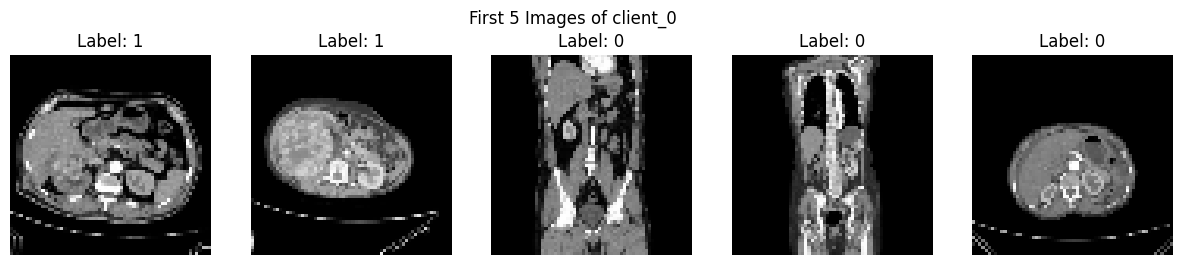

Client: client_1


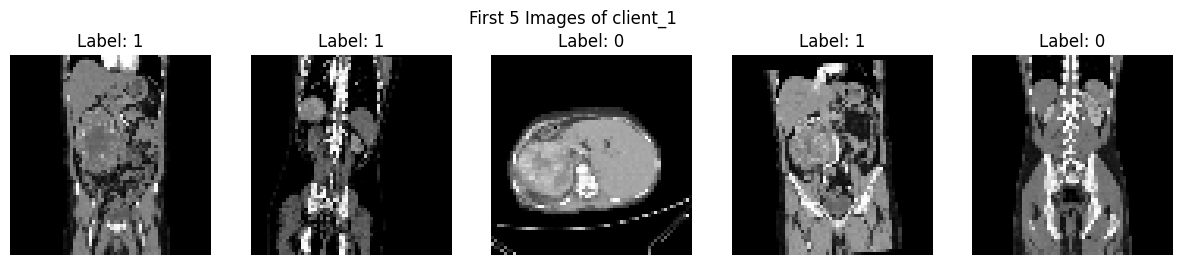

Client: client_2


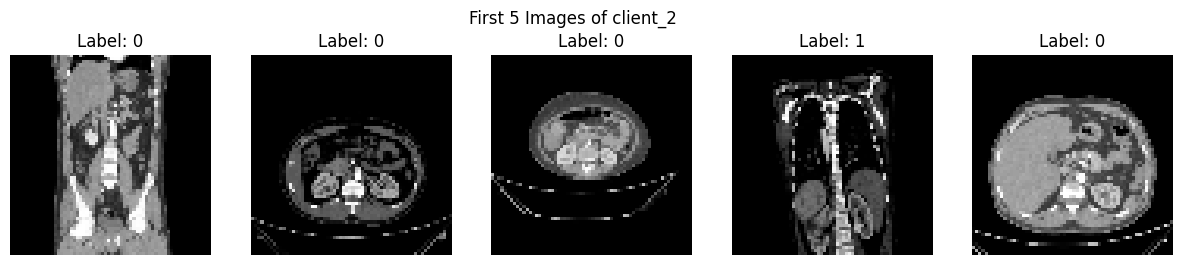

Client: client_3


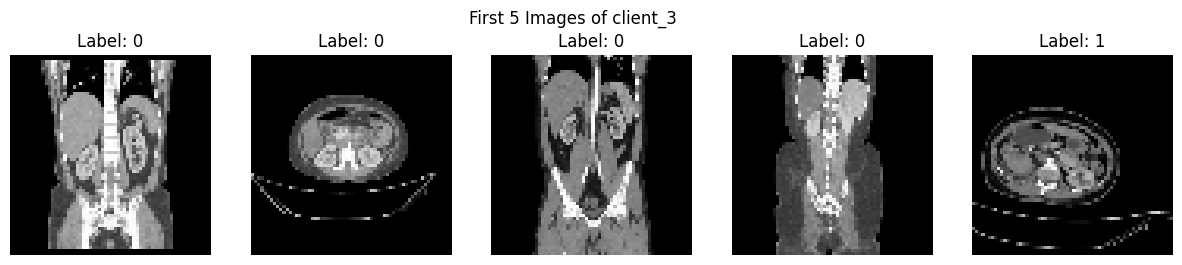

Client: client_4


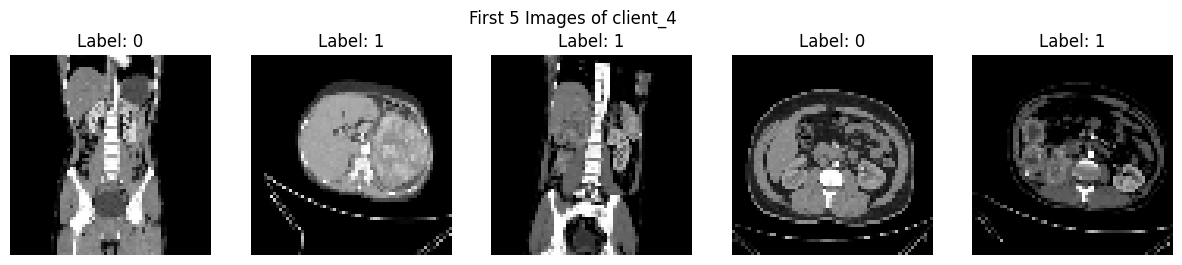

Client: client_5


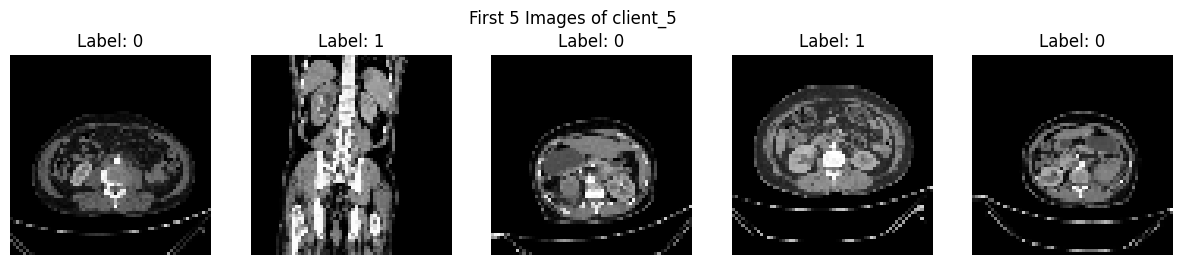

Client: client_6


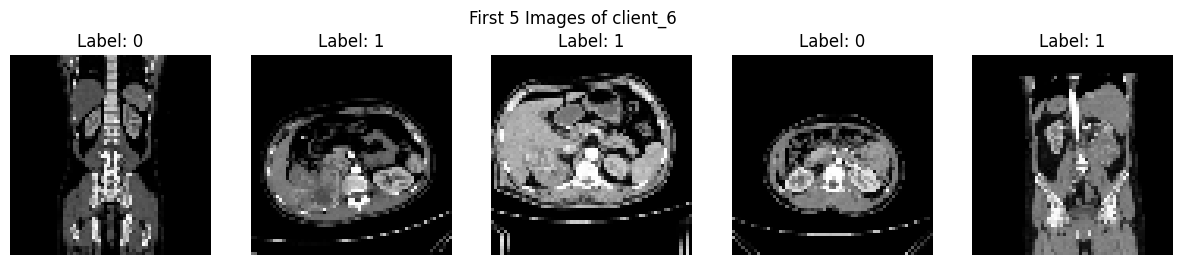

Client: client_7


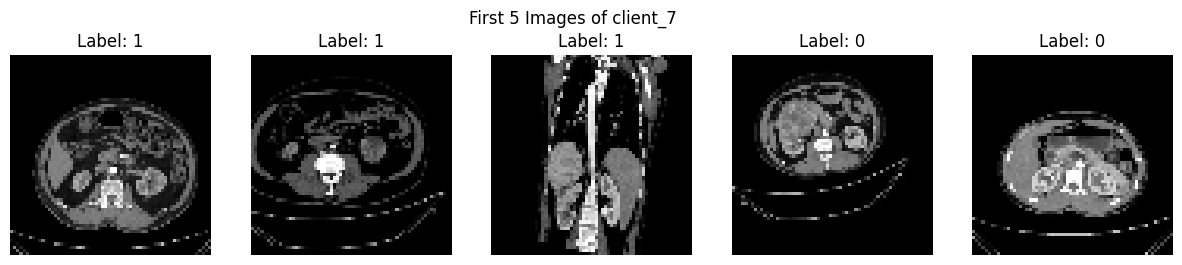

Client: client_8


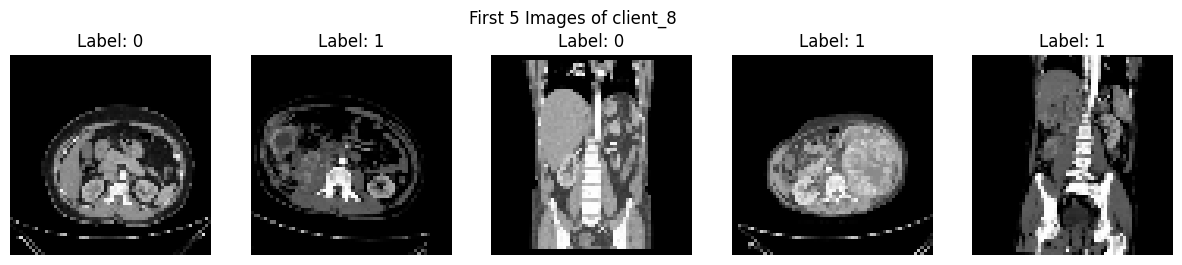

Client: client_9


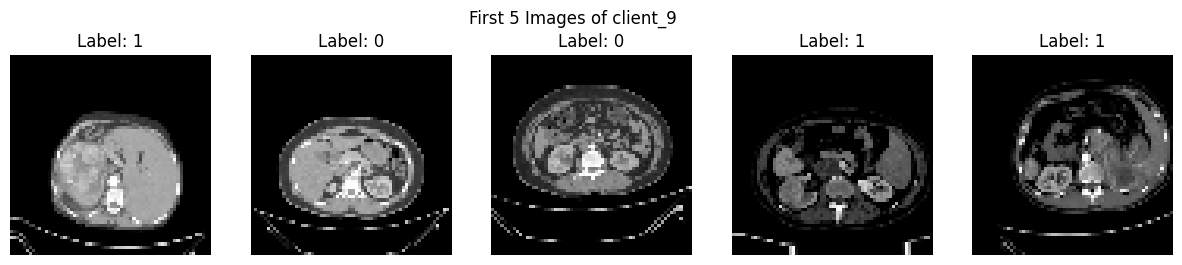

In [13]:
import matplotlib.pyplot as plt

def show_images_with_labels(images, labels, title=None):
    plt.figure(figsize=(15, 3))
    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

def print_first_5_images_with_labels(clients_datasets):
    for client_id, dataset in clients_datasets.items():
        print(f"Client: {client_id}")

        images_collected = []
        labels_collected = []
        for batch_images, batch_labels in dataset.take(1):
            images_slice = batch_images[:5]
            labels_slice = batch_labels[:5]
            batch_np_images = images_slice.numpy()
            batch_np_labels = labels_slice.numpy()
            for img, lbl in zip(batch_np_images, batch_np_labels):
                images_collected.append(img)
                labels_collected.append(lbl)

        show_images_with_labels(images_collected, labels_collected, title=f"First 5 Images of {client_id}")


print_first_5_images_with_labels(client_datasets)

In [14]:
for images, labels in client_datasets['client_0'].take(1):
    print(images.shape)
    print(labels.shape)
    print(labels)

(8, 64, 64, 3)
(8,)
tf.Tensor([0 1 1 0 0 1 0 0], shape=(8,), dtype=int32)


In [15]:
def create_keras_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')  # For 2-class classification
    ])
    return model


In [16]:
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=client_datasets['client_0'].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

In [17]:
keras_model = create_keras_model()
tff_model = tff.learning.models.functional_model_from_keras(
        keras_model,
        input_spec=client_datasets['client_0'].element_spec,
        loss_fn =tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics_constructor = collections.OrderedDict(
            accuracy = tf.keras.metrics.SparseCategoricalAccuracy
        )
    )

2026-02-16 11:17:01.667049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-16 11:17:01.668160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-16 11:17:01.669002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [18]:
sample_model = create_keras_model()

sample_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # for one-hot or multi-class
    metrics=['accuracy']
)

In [19]:
sample_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 128)        

In [20]:
with tf.device('/GPU:0'):
    sample_model.fit(client_datasets['client_0'], epochs=5, verbose=2)

Epoch 1/5


2026-02-16 11:17:02.410177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2026-02-16 11:17:03.461352: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x16cd4300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-16 11:17:03.461397: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2026-02-16 11:17:03.469781: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-16 11:17:03.551933: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 3s - loss: 0.6565 - accuracy: 0.5960 - 3s/epoch - 65ms/step
Epoch 2/5
44/44 - 0s - loss: 0.4908 - accuracy: 0.8080 - 118ms/epoch - 3ms/step
Epoch 3/5
44/44 - 0s - loss: 0.3304 - accuracy: 0.8768 - 165ms/epoch - 4ms/step
Epoch 4/5
44/44 - 0s - loss: 0.2086 - accuracy: 0.9140 - 136ms/epoch - 3ms/step
Epoch 5/5
44/44 - 0s - loss: 0.1099 - accuracy: 0.9570 - 157ms/epoch - 4ms/step


In [21]:
@tff.tensorflow.computation
def server_init():
    return tff.learning.models.ModelWeights(*tff_model.initial_weights)

In [22]:
@tff.federated_computation
def initialize_fn():
  return tff.federated_eval(server_init, tff.SERVER)

In [23]:
tf_dataset_type = tff.SequenceType(
    tff.types.tensorflow_to_type(tff_model.input_spec)
)

In [24]:
model_weights_type = server_init.type_signature.result

In [25]:
str(tf_dataset_type)

'<float32[?,64,64,3],int32[?]>*'

In [26]:
str(model_weights_type)

'<trainable=<float32[3,3,3,32],float32[32],float32[3,3,32,64],float32[64],float32[3,3,64,128],float32[128],float32[4608,128],float32[128],float32[128,2],float32[2]>,non_trainable=<>>'

In [27]:
@tf.function
#@tff.tensorflow.computation
def client_update(model, dataset, initial_weights, client_optimizer):
  """Performs training (using the server model weights) on the client's dataset."""
  # Initialize the client model with the current server weights and the optimizer
  # state.
  client_weights = initial_weights.trainable
  optimizer_state = client_optimizer.initialize(
      tf.nest.map_structure(tf.TensorSpec.from_tensor, client_weights)
  )

  # Use the client_optimizer to update the local model.
  for batch in dataset:
    x, y = batch
    with tf.GradientTape() as tape:
      tape.watch(client_weights)
      # Compute a forward pass on the batch of data
      outputs = model.predict_on_batch(
          model_weights=(client_weights, ()), x=x, training=True
      )
      loss = model.loss(output=outputs, label=y)

    # Compute the corresponding gradient
    grads = tape.gradient(loss, client_weights)

    # Apply the gradient using a client optimizer.
    optimizer_state, client_weights = client_optimizer.next(
        optimizer_state, weights=client_weights, gradients=grads
    )

    ##in_client_update_method.append(grads)

  weights = tff.learning.models.ModelWeights(client_weights, non_trainable=())
  return weights

In [28]:
@tff.tensorflow.computation(tf_dataset_type, model_weights_type)
def client_update_fn(tf_dataset, server_weights):
  client_optimizer = tff.learning.optimizers.build_sgdm(learning_rate=0.01)
  return client_update(tff_model, tf_dataset, server_weights, client_optimizer)

In [29]:
@tf.function
def server_update(model, mean_client_weights):
  """Updates the server model weights as the average of the client model weights."""
  del model  # Unused, just take the mean_client_weights.
  return mean_client_weights

In [30]:
@tff.tensorflow.computation(model_weights_type)
def server_update_fn(mean_client_weights):
  return server_update(tff_model, mean_client_weights)

In [31]:
federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)

In [32]:
@tff.federated_computation(federated_server_type, federated_dataset_type)
def next_fn(server_weights, federated_dataset):

    server_weights_at_client = tff.federated_broadcast(server_weights)

    client_weights  = tff.federated_map(
        client_update_fn, (federated_dataset, server_weights_at_client)
    )

    mean_client_weights = tff.federated_mean(client_weights)

    server_weights = tff.federated_map(server_update_fn, mean_client_weights)

    return server_weights, client_weights

In [33]:
federated_algorithm = tff.templates.IterativeProcess(
    initialize_fn=initialize_fn,
    next_fn=next_fn
)

In [34]:
str(federated_algorithm.initialize.type_signature)

'( -> <trainable=<float32[3,3,3,32],float32[32],float32[3,3,32,64],float32[64],float32[3,3,64,128],float32[128],float32[4608,128],float32[128],float32[128,2],float32[2]>,non_trainable=<>>@SERVER)'

In [35]:
client_datasets_list = [client_datasets[key] for key in sorted(client_datasets.keys())]
client_datasets_list = list(client_datasets.values())

In [36]:
server_weights = server_init()
captured_client_weights = []
server_weights_track = []

initial_weights = server_weights

for r in range(0, 4):
    server_weights, client_updates = next_fn(server_weights, client_datasets_list)
    captured_client_weights.append(client_updates)
    server_weights_track.append(server_weights)
    print("Finshed Round {}".format(r))

2026-02-16 11:17:06.897179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-16 11:17:06.898209: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2026-02-16 11:17:06.898263: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2026-02-16 11:17:06.898442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-16 11:17:06.899357: I tensorflow/compiler/xla/stream_executor/

Finshed Round 0
Finshed Round 1
Finshed Round 2
Finshed Round 3


In [37]:
len(captured_client_weights[0])

10

In [38]:
len(captured_client_weights)

4

In [39]:
w = list(captured_client_weights[0][1].trainable)

In [40]:
w

[array([[[[ 0.061754  , -0.01368055,  0.05218494, -0.01050166,
           -0.00458389,  0.01725196, -0.05644912, -0.13744189,
            0.04886146,  0.06940331,  0.0005943 ,  0.13493414,
            0.04333504,  0.10884594, -0.13177697, -0.05256379,
           -0.04323088, -0.08709847, -0.10039493,  0.12836576,
           -0.05583818, -0.05580445,  0.03878291, -0.02723696,
            0.1099673 ,  0.02827141, -0.12805223, -0.03372848,
           -0.09269696,  0.12509519,  0.04328422, -0.06177703],
          [ 0.02443709, -0.0265486 ,  0.07816914,  0.0828908 ,
            0.08803725, -0.02519726,  0.01126077,  0.11266881,
           -0.09975743,  0.04039486, -0.03191696,  0.11869375,
           -0.04897239, -0.11902055, -0.00187099,  0.07336909,
           -0.09072388, -0.00240834,  0.08672656,  0.10776952,
            0.05604118, -0.07013021,  0.00103079, -0.02317759,
            0.00910334, -0.12298821, -0.03925921,  0.02295081,
            0.01336476, -0.07937843, -0.00699324, -0.1

In [41]:
client_weights = {}

In [42]:
for i in range(len(captured_client_weights)):
    client_weights["round" + str(i) + "weights"] = {}
    for j in range(len(captured_client_weights[i])):
        model_weights = list(captured_client_weights[i][j].trainable)
        model_to_flats = [tf.reshape(w, [-1]) for w in model_weights]
        flats_to_vector = tf.concat(model_to_flats, axis=0)
        client_weights["round" + str(i) + "weights"]["client_"+ str(j)] = flats_to_vector

In [43]:
client_weights

{'round0weights': {'client_0': <tf.Tensor: shape=(683458,), dtype=float32, numpy=
  array([ 0.06186118, -0.01412349,  0.05106379, ...,  0.18495516,
         -0.00527206,  0.00527206], dtype=float32)>,
  'client_1': <tf.Tensor: shape=(683458,), dtype=float32, numpy=
  array([ 0.061754  , -0.01368055,  0.05218494, ...,  0.1853068 ,
         -0.0035127 ,  0.0035127 ], dtype=float32)>,
  'client_2': <tf.Tensor: shape=(683458,), dtype=float32, numpy=
  array([ 0.06168678, -0.01344061,  0.05154145, ...,  0.1852948 ,
         -0.01702177,  0.01702177], dtype=float32)>,
  'client_3': <tf.Tensor: shape=(683458,), dtype=float32, numpy=
  array([ 0.0619371 , -0.01371287,  0.0519031 , ...,  0.18534599,
         -0.00543259,  0.00543259], dtype=float32)>,
  'client_4': <tf.Tensor: shape=(683458,), dtype=float32, numpy=
  array([ 0.0615119 , -0.01376508,  0.05127362, ...,  0.18457663,
         -0.00829562,  0.00829562], dtype=float32)>,
  'client_5': <tf.Tensor: shape=(683458,), dtype=float32, numpy

In [44]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

def cluster_one_round(client_weights_dict, n_clusters=2, pca_var=0.95):
    """
    client_weights_dict: {"client_0": tf.Tensor shape (D,), ..., "client_9": tf.Tensor shape (D,)}
    returns: labels (len=10), Z (10 x k), client_keys (ordered)
    """
    client_keys = sorted(client_weights_dict.keys(), key=lambda s: int(s.split("_")[1]))

    # Stack to (10, D)
    X = np.stack([client_weights_dict[k].numpy() for k in client_keys], axis=0).astype(np.float32)

    # Center/scale across clients (per-feature)
    X = X - X.mean(axis=0, keepdims=True)
    X_std = X.std(axis=0, keepdims=True)
    X_std[X_std == 0] = 1.0
    X_norm = X / X_std

    # PCA (works because n_samples=10, it will choose <=10 components)
    pca = PCA(n_components=pca_var, random_state=42)
    Z = pca.fit_transform(X_norm)

    # Normalize for cosine clustering (avoid zero-vector issues)
    Z_cos = normalize(Z, norm="l2")

    # Cluster
    clusterer = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric="cosine",
        linkage="average"
    )
    labels = clusterer.fit_predict(Z_cos)

    return labels, Z, client_keys


In [46]:
round_cluster_results = {}

for r in range(4):
    round = f"round{r}weights"
    labels, Z, client_keys = cluster_one_round(client_weights[round], n_clusters=2, pca_var=0.95)

    round_cluster_results[round] = {
        "labels": labels,
        "client_keys": client_keys,
        "Z_shape": Z.shape
    }

    print(f"\n{round}  PCA shape={Z.shape}")
    for ck, lab in zip(client_keys, labels):
        print(f"  {ck} -> cluster {lab}")



round0weights  PCA shape=(10, 9)
  client_0 -> cluster 0
  client_1 -> cluster 1
  client_2 -> cluster 0
  client_3 -> cluster 0
  client_4 -> cluster 0
  client_5 -> cluster 1
  client_6 -> cluster 0
  client_7 -> cluster 1
  client_8 -> cluster 0
  client_9 -> cluster 0

round1weights  PCA shape=(10, 9)
  client_0 -> cluster 0
  client_1 -> cluster 1
  client_2 -> cluster 0
  client_3 -> cluster 0
  client_4 -> cluster 0
  client_5 -> cluster 1
  client_6 -> cluster 0
  client_7 -> cluster 1
  client_8 -> cluster 0
  client_9 -> cluster 0

round2weights  PCA shape=(10, 9)
  client_0 -> cluster 0
  client_1 -> cluster 1
  client_2 -> cluster 0
  client_3 -> cluster 0
  client_4 -> cluster 0
  client_5 -> cluster 1
  client_6 -> cluster 0
  client_7 -> cluster 1
  client_8 -> cluster 0
  client_9 -> cluster 0

round3weights  PCA shape=(10, 9)
  client_0 -> cluster 0
  client_1 -> cluster 1
  client_2 -> cluster 0
  client_3 -> cluster 0
  client_4 -> cluster 0
  client_5 -> cluster 1


In [47]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

def cluster_one_round_with_linkage(client_weights_dict, pca_var=0.95):
    client_keys = sorted(client_weights_dict.keys(), key=lambda s: int(s.split("_")[1]))

    # Stack to (n_clients, D)
    X = np.stack([client_weights_dict[k].numpy() for k in client_keys], axis=0).astype(np.float32)

    # Center + scale
    X = X - X.mean(axis=0, keepdims=True)
    X_std = X.std(axis=0, keepdims=True)
    X_std[X_std == 0] = 1.0
    X_norm = X / X_std

    # PCA
    pca = PCA(n_components=pca_var, random_state=42)
    Z = pca.fit_transform(X_norm)

    # Normalize for cosine distance
    Z_cos = normalize(Z, norm="l2")

    # --- Hierarchical linkage (THIS is the agglomerative tree) ---
    linkage_matrix = linkage(
        Z_cos,
        method="average",
        metric="cosine"
    )

    return linkage_matrix, Z, client_keys


In [48]:
def plot_agglomerative_dendrogram(linkage_matrix, client_keys, round_name):
    plt.figure(figsize=(10, 5))
    dendrogram(
        linkage_matrix,
        labels=[ck.replace("client_", "C") for ck in client_keys],
        leaf_rotation=0,
        leaf_font_size=11,
        color_threshold=None
    )

    plt.title(
        f"{round_name}: Agglomerative Clustering Dendrogram\n"
        "(Average Linkage + Cosine Distance)",
        fontsize=14,
        weight="bold"
    )
    plt.xlabel("Clients")
    plt.ylabel("Cosine Distance")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


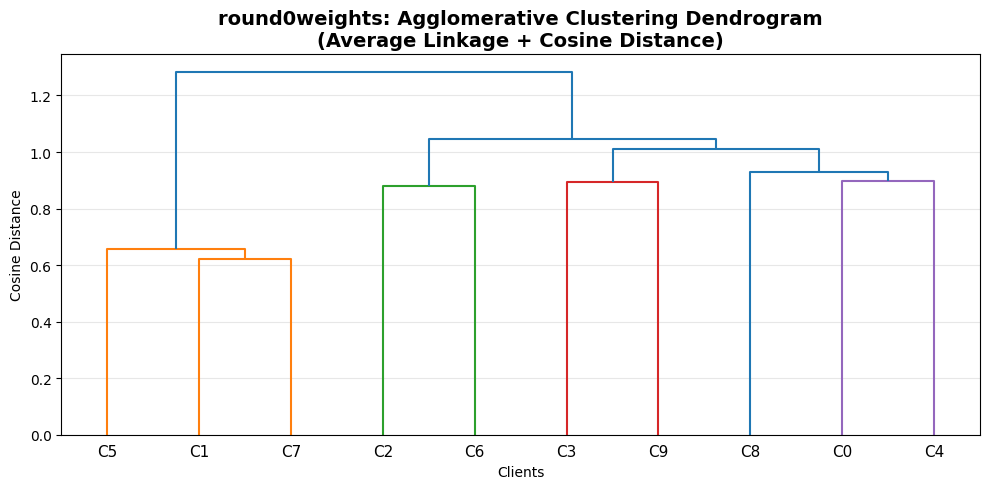

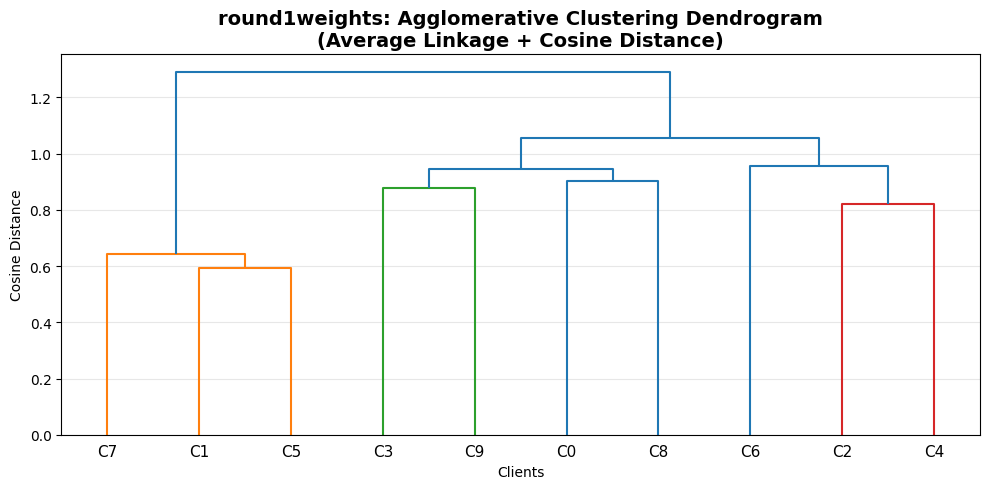

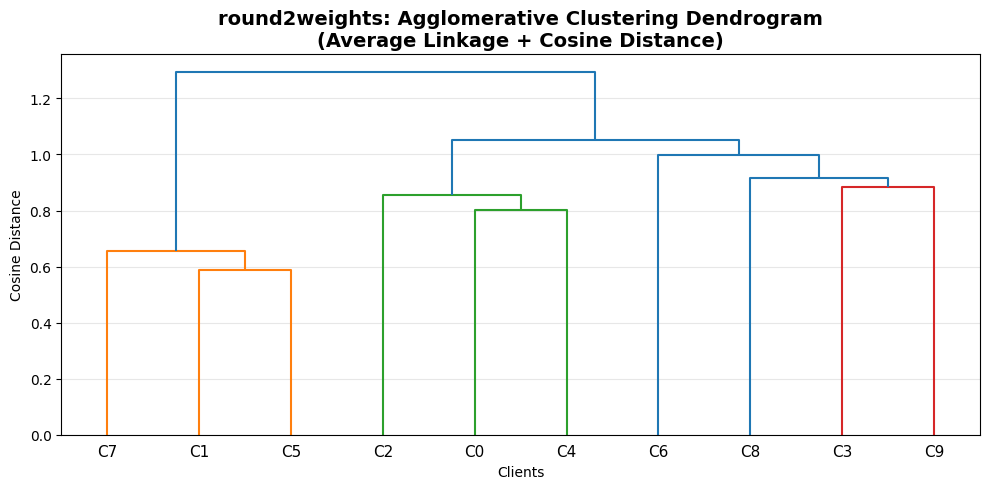

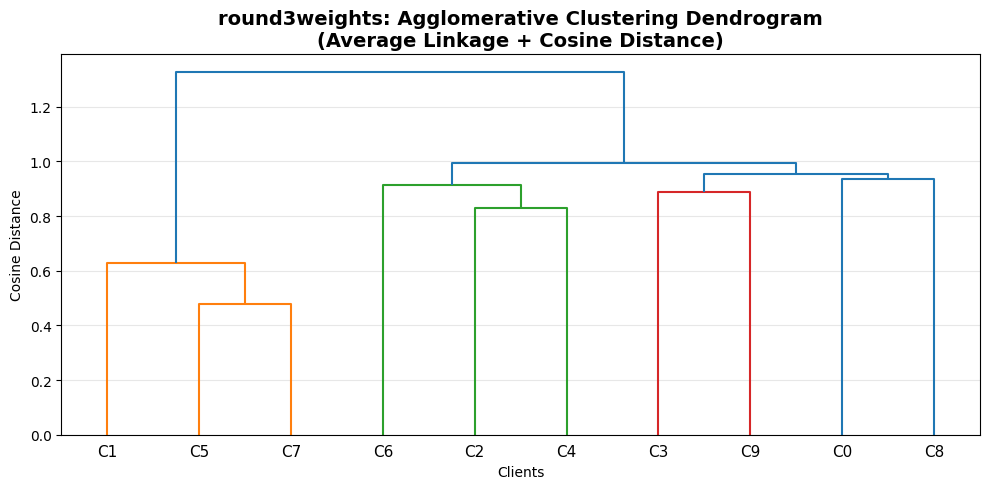

In [49]:
for r in range(4):
    rk = f"round{r}weights"
    linkage_matrix, Z, client_keys = cluster_one_round_with_linkage(
        client_weights[rk],
        pca_var=0.95
    )

    plot_agglomerative_dendrogram(linkage_matrix, client_keys, rk)


In [50]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import hdbscan

def hdbscan_one_round(client_weights_dict, pca_var=0.95,
                      min_cluster_size=2, min_samples=1):
    client_keys = sorted(client_weights_dict.keys(), key=lambda s: int(s.split("_")[1]))

    # (n_clients, D)
    X = np.stack([client_weights_dict[k].numpy() for k in client_keys], axis=0).astype(np.float32)

    # Center/scale per-feature across clients
    X = X - X.mean(axis=0, keepdims=True)
    X_std = X.std(axis=0, keepdims=True)
    X_std[X_std == 0] = 1.0
    X_norm = X / X_std

    # PCA -> lower-dim features (stable for clustering + visualization)
    pca = PCA(n_components=pca_var, random_state=42)
    Z = pca.fit_transform(X_norm)

    # Normalize so cosine distance focuses on direction
    Z_cos = normalize(Z, norm="l2")

    # HDBSCAN: cosine metric + variable number of clusters + noise handling
    clusterer = hdbscan.HDBSCAN(
        metric="euclidean",
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_method="eom",   # typical default
    )
    labels = clusterer.fit_predict(Z_cos)          # -1 means noise/outlier
    probs  = clusterer.probabilities_              # confidence per point (0..1)

    return labels, probs, Z, client_keys, clusterer


In [51]:
import matplotlib.pyplot as plt

def plot_hdbscan_round(rk, labels, probs, Z, client_keys):
    # 2D coords
    if Z.shape[1] >= 2:
        x, y = Z[:, 0], Z[:, 1]
        xlab, ylab = "PCA-1", "PCA-2"
    else:
        x, y = Z[:, 0], np.zeros_like(Z[:, 0])
        xlab, ylab = "PCA-1", "0"

    plt.figure(figsize=(8, 6))
    plt.style.use("seaborn-v0_8-whitegrid")

    # noise = -1
    unique = sorted(set(labels))
    for lab in unique:
        idx = (labels == lab)
        if lab == -1:
            # noise points
            plt.scatter(x[idx], y[idx], s=180, marker="x", linewidths=2, alpha=0.9, label="Noise (-1)")
        else:
            # size reflects membership confidence
            sizes = 120 + 300 * probs[idx]
            plt.scatter(x[idx], y[idx], s=sizes, alpha=0.85, edgecolor="black", linewidth=1.0, label=f"Cluster {lab}")

    for i, ck in enumerate(client_keys):
        plt.text(x[i] + 0.02, y[i] + 0.02, ck.replace("client_", "C"),
                 fontsize=10, weight="bold")

    plt.title(f"{rk}: HDBSCAN (cosine) on PCA features", fontsize=14, weight="bold")
    plt.xlabel(xlab); plt.ylabel(ylab)
    plt.legend(frameon=True, fancybox=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



round0weights
  client_0 -> label 1   prob=1.000
  client_1 -> label 0   prob=1.000
  client_2 -> label 1   prob=1.000
  client_3 -> label 1   prob=1.000
  client_4 -> label 1   prob=1.000
  client_5 -> label 0   prob=0.990
  client_6 -> label 1   prob=1.000
  client_7 -> label 0   prob=1.000
  client_8 -> label 1   prob=1.000
  client_9 -> label 1   prob=1.000


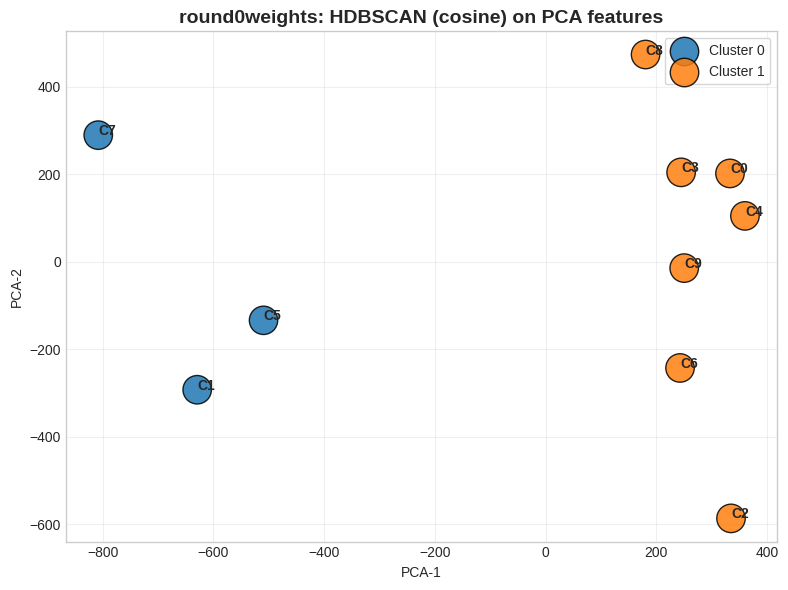


round1weights
  client_0 -> label 1   prob=1.000
  client_1 -> label 0   prob=1.000
  client_2 -> label 1   prob=1.000
  client_3 -> label 1   prob=1.000
  client_4 -> label 1   prob=1.000
  client_5 -> label 0   prob=1.000
  client_6 -> label 1   prob=0.984
  client_7 -> label 0   prob=0.972
  client_8 -> label 1   prob=1.000
  client_9 -> label 1   prob=1.000


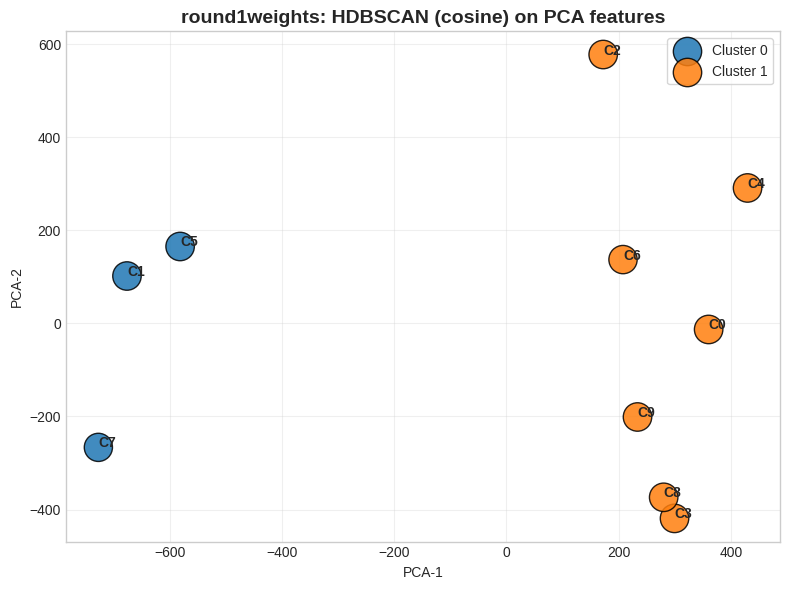


round2weights
  client_0 -> label 1   prob=1.000
  client_1 -> label 0   prob=1.000
  client_2 -> label 1   prob=1.000
  client_3 -> label 1   prob=1.000
  client_4 -> label 1   prob=1.000
  client_5 -> label 0   prob=1.000
  client_6 -> label 1   prob=0.994
  client_7 -> label 0   prob=0.964
  client_8 -> label 1   prob=1.000
  client_9 -> label 1   prob=1.000


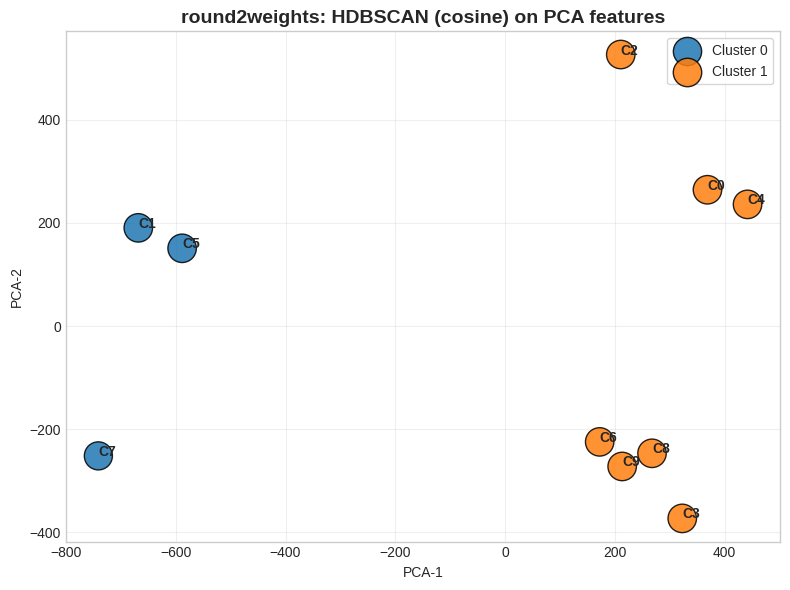


round3weights
  client_0 -> label 1   prob=1.000
  client_1 -> label 0   prob=0.879
  client_2 -> label 1   prob=1.000
  client_3 -> label 1   prob=1.000
  client_4 -> label 1   prob=1.000
  client_5 -> label 0   prob=1.000
  client_6 -> label 1   prob=1.000
  client_7 -> label 0   prob=1.000
  client_8 -> label 1   prob=1.000
  client_9 -> label 1   prob=1.000


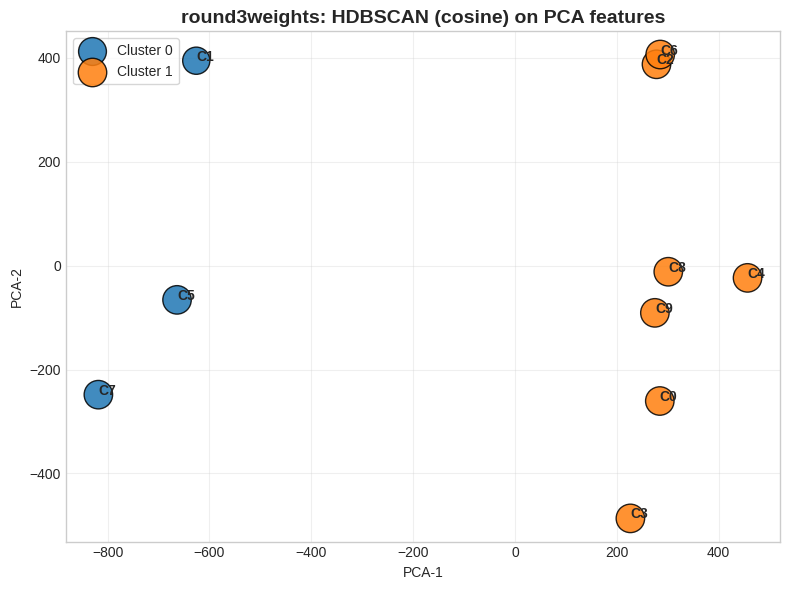

In [52]:
round_hdbscan_results = {}

for r in range(4):
    rk = f"round{r}weights"
    labels, probs, Z, client_keys, clusterer = hdbscan_one_round(
        client_weights[rk],
        pca_var=0.95,
        min_cluster_size=2,
        min_samples=1
    )

    round_hdbscan_results[rk] = {
        "labels": labels,
        "probs": probs,
        "client_keys": client_keys,
        "Z": Z
    }

    print(f"\n{rk}")
    for ck, lab, pr in zip(client_keys, labels, probs):
        print(f"  {ck} -> label {lab}   prob={pr:.3f}")

    plot_hdbscan_round(rk, labels, probs, Z, client_keys)


In [53]:
def vector_magnitude(w):
    if isinstance(w, tf.Tensor):
        w = w.numpy()
    return np.linalg.norm(w, ord=2)

In [54]:
def vector_direction(w, eps=1e-12):
    if isinstance(w, tf.Tensor):
        w = w.numpy()
    mag = np.linalg.norm(w)
    return w / (mag + eps)


In [55]:
round_magnitudes = {}
round_directions = {}

for r in range(4):
    rk = f"round{r}weights"
    round_magnitudes[rk] = {}
    round_directions[rk] = {}

    for ck, w in client_weights[rk].items():
        mag = vector_magnitude(w)
        direction = vector_direction(w)

        round_magnitudes[rk][ck] = mag
        round_directions[rk][ck] = direction

        print(f"{rk} | {ck} | magnitude = {mag:.4f}")


round0weights | client_0 | magnitude = 19.6552
round0weights | client_1 | magnitude = 19.6543
round0weights | client_2 | magnitude = 19.6551
round0weights | client_3 | magnitude = 19.6553
round0weights | client_4 | magnitude = 19.6553
round0weights | client_5 | magnitude = 19.6545
round0weights | client_6 | magnitude = 19.6551
round0weights | client_7 | magnitude = 19.6546
round0weights | client_8 | magnitude = 19.6552
round0weights | client_9 | magnitude = 19.6551
round1weights | client_0 | magnitude = 19.6561
round1weights | client_1 | magnitude = 19.6547
round1weights | client_2 | magnitude = 19.6560
round1weights | client_3 | magnitude = 19.6563
round1weights | client_4 | magnitude = 19.6564
round1weights | client_5 | magnitude = 19.6549
round1weights | client_6 | magnitude = 19.6561
round1weights | client_7 | magnitude = 19.6548
round1weights | client_8 | magnitude = 19.6564
round1weights | client_9 | magnitude = 19.6564
round2weights | client_0 | magnitude = 19.6578
round2weights

In [56]:
import numpy as np
import tensorflow as tf

def angle_between_vectors(w1, w2, eps=1e-12):
    if isinstance(w1, tf.Tensor):
        w1 = w1.numpy()
    if isinstance(w2, tf.Tensor):
        w2 = w2.numpy()

    dot = np.dot(w1, w2)
    norm1 = np.linalg.norm(w1)
    norm2 = np.linalg.norm(w2)

    cos_sim = dot / (norm1 * norm2 + eps)
    cos_sim = np.clip(cos_sim, -1.0, 1.0)

    angle_rad = np.arccos(cos_sim)
    angle_deg = np.degrees(angle_rad)
    return angle_deg


In [57]:
def print_all_client_angle_differences(client_weights_round):
    """
    client_weights_round:
      {"client_0": vector, "client_1": vector, ...}
    """
    client_keys = sorted(
        client_weights_round.keys(),
        key=lambda s: int(s.split("_")[1])
    )

    print("\nPairwise angle differences (degrees):")

    for i in range(len(client_keys)):
        for j in range(i + 1, len(client_keys)):
            c1 = client_keys[i]
            c2 = client_keys[j]

            angle = angle_between_vectors(
                client_weights_round[c1],
                client_weights_round[c2]
            )

            print(f"  {c1}  ↔  {c2} : {angle:.3f}°")


In [58]:
for r in range(4):
    rk = f"round{r}weights"
    print(f"\n================ {rk} ================")
    print_all_client_angle_differences(client_weights[rk])



================ round0weights ================

Pairwise angle differences (degrees):
  client_0  ↔  client_1 : 0.251°
  client_0  ↔  client_2 : 0.196°
  client_0  ↔  client_3 : 0.181°
  client_0  ↔  client_4 : 0.167°
  client_0  ↔  client_5 : 0.231°
  client_0  ↔  client_6 : 0.188°
  client_0  ↔  client_7 : 0.263°
  client_0  ↔  client_8 : 0.158°
  client_0  ↔  client_9 : 0.167°
  client_1  ↔  client_2 : 0.231°
  client_1  ↔  client_3 : 0.239°
  client_1  ↔  client_4 : 0.222°
  client_1  ↔  client_5 : 0.163°
  client_1  ↔  client_6 : 0.209°
  client_1  ↔  client_7 : 0.172°
  client_1  ↔  client_8 : 0.254°
  client_1  ↔  client_9 : 0.227°
  client_2  ↔  client_3 : 0.240°
  client_2  ↔  client_4 : 0.169°
  client_2  ↔  client_5 : 0.230°
  client_2  ↔  client_6 : 0.188°
  client_2  ↔  client_7 : 0.310°
  client_2  ↔  client_8 : 0.251°
  client_2  ↔  client_9 : 0.185°
  client_3  ↔  client_4 : 0.176°
  client_3  ↔  client_5 : 0.243°
  client_3  ↔  client_6 : 0.200°
  client_3  ↔  client

In [59]:
len(server_weights_track)

4

In [60]:
server_weights_vector = {}

for i in range(len(server_weights_track)):
    model_weights = list(server_weights_track[i].trainable)
    model_to_flats = [tf.reshape(w, [-1]) for w in model_weights]
    flats_to_vector = tf.concat(model_to_flats, axis=0)
    server_weights_vector["round" + str(i)] = flats_to_vector

In [61]:
len(server_weights_vector)

4

In [62]:
server_client_angles = {}

num_rounds = len(server_weights_vector)

for r in range(num_rounds):
    rk_server = f"round{r}"
    rk_client = f"round{r}weights"

    s_vec = server_weights_vector[rk_server]

    # sort clients by index
    client_keys = sorted(client_weights[rk_client].keys(), key=lambda s: int(s.split("_")[1]))

    server_client_angles[rk_client] = {}

    print(f"\n=== {rk_client}: angle(client, server_round{r}) (degrees) ===")

    for ck in client_keys:
        c_vec = client_weights[rk_client][ck]

        # sanity check (dimensions must match)
        if int(c_vec.shape[0]) != int(s_vec.shape[0]):
            raise ValueError(
                f"Vector length mismatch in {rk_client} {ck}: "
                f"client={int(c_vec.shape[0])}, server={int(s_vec.shape[0])}. "
                f"Make sure you flattened the same weight set/order."
            )

        deg = angle_between_vectors(c_vec, s_vec)
        server_client_angles[rk_client][ck] = deg

        print(f"  {ck} -> {deg:.3f}°")



=== round0weights: angle(client, server_round0) (degrees) ===
  client_0 -> 0.153°
  client_1 -> 0.159°
  client_2 -> 0.169°
  client_3 -> 0.129°
  client_4 -> 0.107°
  client_5 -> 0.175°
  client_6 -> 0.154°
  client_7 -> 0.188°
  client_8 -> 0.149°
  client_9 -> 0.112°

=== round1weights: angle(client, server_round1) (degrees) ===
  client_0 -> 0.125°
  client_1 -> 0.182°
  client_2 -> 0.154°
  client_3 -> 0.144°
  client_4 -> 0.116°
  client_5 -> 0.121°
  client_6 -> 0.114°
  client_7 -> 0.161°
  client_8 -> 0.161°
  client_9 -> 0.109°

=== round2weights: angle(client, server_round2) (degrees) ===
  client_0 -> 0.156°
  client_1 -> 0.170°
  client_2 -> 0.175°
  client_3 -> 0.161°
  client_4 -> 0.142°
  client_5 -> 0.182°
  client_6 -> 0.142°
  client_7 -> 0.195°
  client_8 -> 0.148°
  client_9 -> 0.133°

=== round3weights: angle(client, server_round3) (degrees) ===
  client_0 -> 0.146°
  client_1 -> 0.195°
  client_2 -> 0.153°
  client_3 -> 0.182°
  client_4 -> 0.149°
  client_5 ->

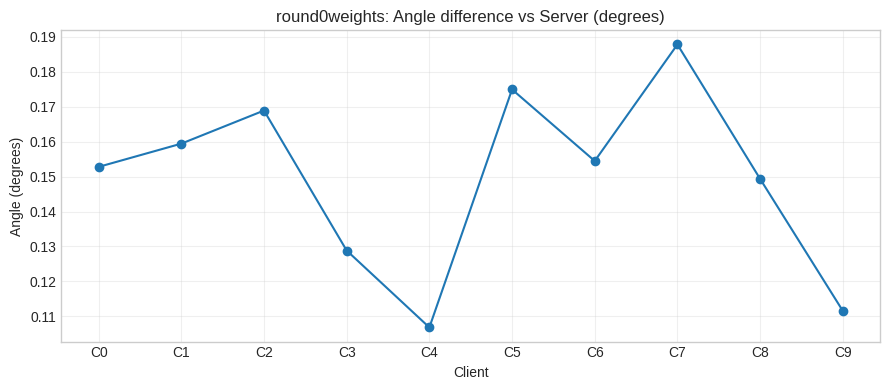

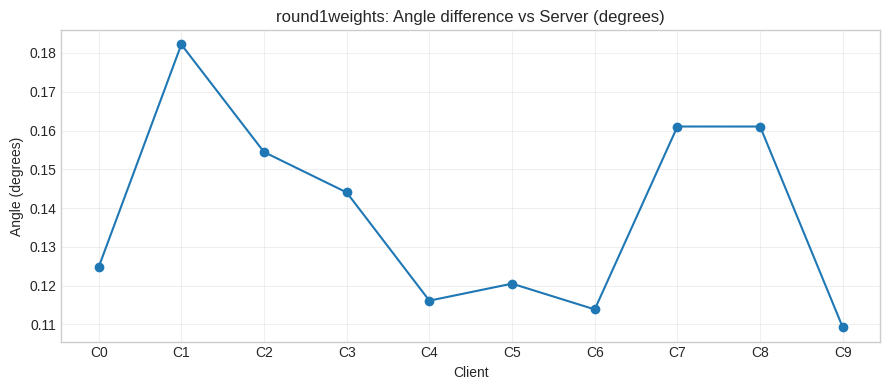

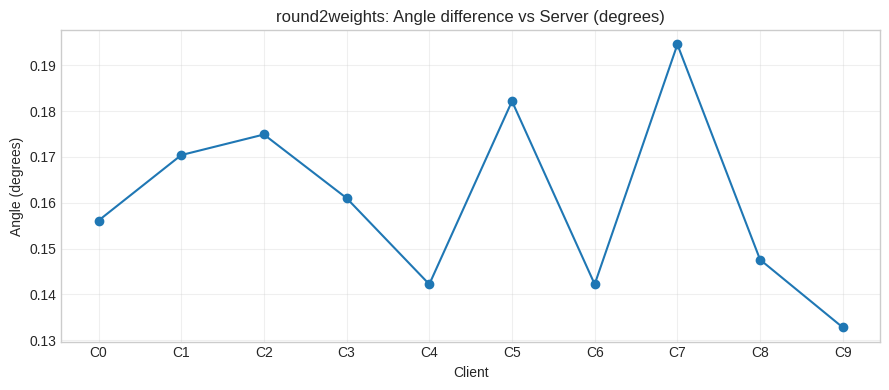

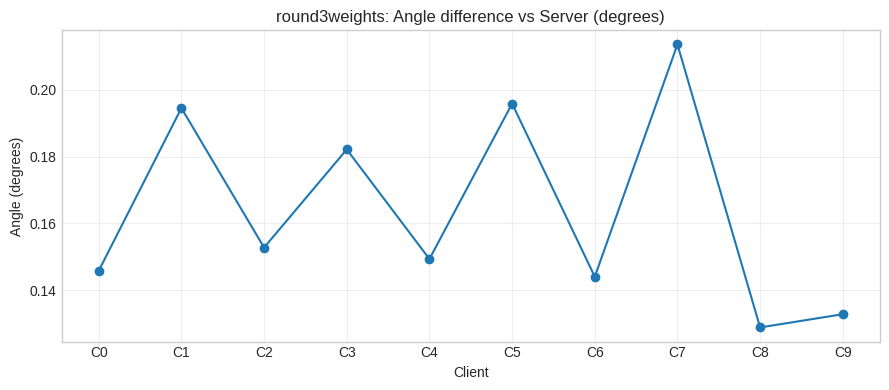

In [63]:
import matplotlib.pyplot as plt

for r in range(num_rounds):
    rk_client = f"round{r}weights"
    client_keys = sorted(server_client_angles[rk_client].keys(), key=lambda s: int(s.split("_")[1]))
    angles = [server_client_angles[rk_client][ck] for ck in client_keys]
    x = list(range(len(client_keys)))

    plt.figure(figsize=(9, 4))
    plt.plot(x, angles, marker="o")
    plt.xticks(x, [ck.replace("client_", "C") for ck in client_keys])
    plt.title(f"{rk_client}: Angle difference vs Server (degrees)")
    plt.xlabel("Client")
    plt.ylabel("Angle (degrees)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
